In [1]:
# import standard libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import sys

import warnings
import pandas as pd

from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

import datetime
import pickle
from nltk.corpus import stopwords
import re
import regex
import string
from urllib.parse import urlparse

In [2]:
# import ML libraries
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset

In [3]:
# import evaluation libraries
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, accuracy_score

In [4]:
sys.path.insert(0, '//wsl$/Ubuntu/home/zaidek/Part-II-Disertation/Neural Networks')

In [5]:
# load required models
from ipynb.fs.defs.models import FFNonEmbedding

In [6]:
# load required test datasets
from ipynb.fs.defs.datasets import NonEmbeddingDataset

In [7]:
from eval_helper import evaluate_model, plot_classification_metrics, plot_losses, plot_losses_log

In [8]:
# import testing data
req_cols_without_url = ["title", "text", "time", "url", "descendants"]
cutoff = 20
batch_size = 1
with open("../../data/data_test", "rb") as fb:
    testing_data = pickle.load(fb)
testing_data_indexed = testing_data.reset_index(drop=True)
testing_scores = testing_data_indexed.score
testing_data_indexed = testing_data_indexed[req_cols_without_url]
testing_data_indexed.title = testing_data_indexed.title.fillna("")
testing_data_indexed.text = testing_data_indexed.text.fillna("")
testing_data_indexed.url = testing_data_indexed.url.fillna("")
testing_data_indexed.time = testing_data_indexed.time.fillna(0)
testing_data_indexed.descendants = testing_data_indexed.descendants.fillna(0)


dataset = NonEmbeddingDataset(testing_data_indexed, testing_scores, cutoff)
data_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=False)

In [9]:
# define loss function
loss_func = nn.BCEWithLogitsLoss()

In [10]:
# load models
bert_model = FFNonEmbedding(1, 8)
bert_model.load_state_dict(torch.load("../trained_models/bert_model_best_7.pth"))
bert_model.eval()

FFNonEmbedding(
  (hidden): Sequential(
    (0): Linear(in_features=8, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [11]:
eval_1 = evaluate_model(data_loader, bert_model, loss_func, "cpu")

In [12]:
t = eval_1[0][0]
print(t)
print(t.detach().squeeze(1))

tensor([[-5.2947]], grad_fn=<AddmmBackward0>)
tensor([-5.2947])


\\wsl$\Ubuntu\home\zaidek\Part-II-Disertation\Neural Networks\evaluation\eval_helper.py:67: RuntimeWarning: divide by zero encountered in log
  plt.plot(np.log(np.arange(len(losses))), losses)


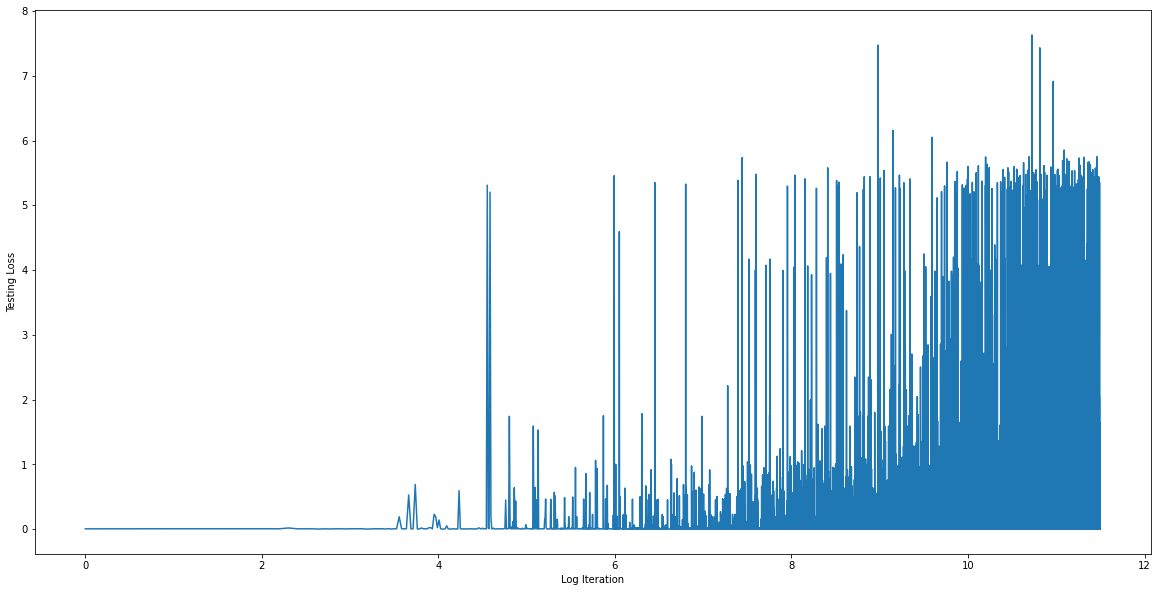

In [13]:
preds, labels, losses = eval_1
preds_2 = [0 if nn.Sigmoid()(pred.detach().squeeze(1)) < 0.5 else 1 for pred in preds]
labels_2 = [label.detach().item() for label in labels]
losses_2 = [loss.detach() for loss in losses]
plot_losses_log(losses_2, "Testing Loss")

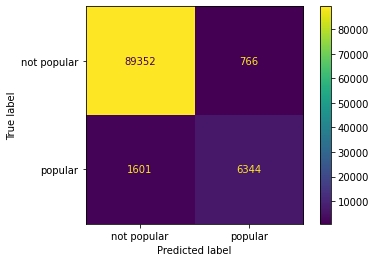

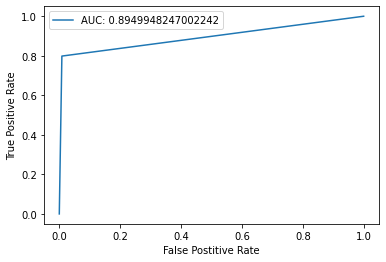

In [14]:
plot_classification_metrics(labels_2, preds_2)

In [15]:
with open("../losses/LossWithComments", "rb") as fb:
    losses_with_comments = pickle.load(fb)

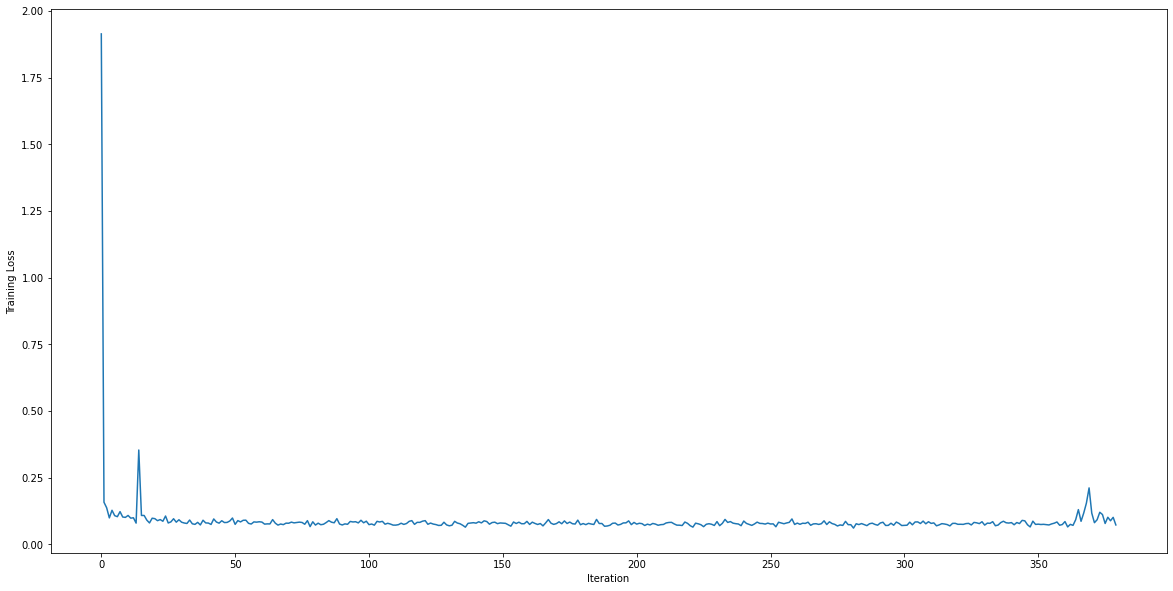

In [16]:
plot_losses(losses_with_comments, "Training Loss")